In [1]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
# import torch
#from torch import nn
#from torch.utils.data import DataLoader
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# from utils import train, test
import tensorflow as tf
import keras
from keras import models, layers
# from keras.models import Sequential
# from keras.layers import Conv1D, BatchNormalization, ReLU, Softmax, MaxPooling1D, LSTM, Dropout, Dense
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot


2023-12-07 20:14:49.714391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 20:14:49.714459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 20:14:49.715534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 20:14:49.722582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 20:14:50.515692: W tensorflow/compiler/tf2

# Data Loader

In [2]:
# mac
#sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
# sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
# label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [3]:
in_channels = data.shape[2]
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

in_channels:  9
data.shape:  (25595, 50, 9)


In [4]:
label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, 9)
# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data.shape: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



# device = (
#      "cuda"
#      if torch.cuda.is_available()
#      else "cpu"
#  )
# #device = "cpu"
# print(f"Using {device} device")

B_size:  25020
A_size:  575
data.shape:  [ 2.46000000e-01 -1.01900000e+00 -4.40000000e-02  3.33461556e+01
  4.35448080e+00  2.16005166e+01  8.58061901e+01  8.07870780e-01
 -1.70919101e+02]
(250, 50, 9)


# Hyperparameters

In [5]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ResNet24

In [51]:
class ConvBlock(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=16, kernel_size=(1, 1))
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.conv3 = layers.Conv2D(filters=64, kernel_size=(1, 1))
        self.bn3 = layers.BatchNormalization()
        self.relu3 = layers.ReLU()
        self.convr = layers.Conv2D(filters=64, kernel_size=(1, 1))
        self.add = layers.Add()

    def call(self, inputs):
        residual = self.convr(inputs)
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.add([x, residual])
        x = self.relu3(x)
        return x

class IdentityBlock(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=16, kernel_size=(1, 1))
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.conv3 = layers.Conv2D(filters=64, kernel_size=(1, 1))
        self.bn3 = layers.BatchNormalization()
        self.relu3 = layers.ReLU()
        self.add = layers.Add()

    def call(self, inputs):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.add([x, residual])
        x = self.relu3(x)
        return x

# class ResNet(keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.reshape = layers.Reshape((1, 50, 9))
#         self.conv1 = layers.Conv2D(filters=64, kernel_size=(1, 3))
#         self.conv2 = layers.Conv2D(filters=64, kernel_size=(1, 3))
#         self.pool1 = layers.MaxPooling2D(pool_size=(1, 2))
        
#         self.convblk1 = ConvBlock()
#         self.convblk2 = ConvBlock()
#         self.identityblk1 = IdentityBlock()
#         self.convblk3 = ConvBlock()
#         self.identityblk2 = IdentityBlock()
#         self.convblk4 = ConvBlock()
#         self.identityblk3 = IdentityBlock()
        
#         self.pool2 = layers.AveragePooling2D(pool_size=(1, 2))
#         self.flatten = layers.Flatten()      
#         self.fc = layers.Dense(2, activation='softmax')  

#     def call(self, inputs):
#         x = self.reshape(inputs)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.pool1(x)
#         x = self.convblk1(x)
#         x = self.convblk2(x)
#         x = self.identityblk1(x)
#         x = self.convblk3(x)
#         x = self.identityblk2(x)
#         x = self.convblk4(x)
#         x = self.identityblk3(x)
#         x = self.pool2(x)
#         x = self.flatten(x)
#         x = self.fc(x)
#         return x

inputs = keras.Input(shape=(50, 9))
x = layers.Reshape((1, 50, 9))(inputs)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.MaxPooling2D(pool_size=(1, 2))(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

x = layers.AveragePooling2D(pool_size=(1, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)

ResNet24 = keras.Model(inputs=inputs, outputs=outputs, name="ResNet24")

# ResNet24 = models.Sequential([
#     layers.Reshape((1, 50, 9), input_shape=(50, 9)),
#     layers.Conv2D(filters=64, kernel_size=(1, 3)),
#     layers.Conv2D(filters=64, kernel_size=(1, 3)),
#     layers.MaxPooling2D(pool_size=(1, 2)),
#     ConvBlock(),
#     ConvBlock(),
#     IdentityBlock(),
#     ConvBlock(),
#     IdentityBlock(),
#     ConvBlock(),
#     IdentityBlock(),
#     layers.AveragePooling2D(pool_size=(1, 2)),
#     layers.Flatten(),
#     layers.Dense(2, activation='softmax')
# ])

# ResNet24 = ResNet()

In [52]:
# Create an instance of the model
# Create an instance of the model
#model_ConvLSTM = ConvLSTM().to(device)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_ConvLSTM.parameters(), lr=learning_rate)
# Initialize the scheduler
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)
print(f"Model structure: \n")
ResNet24.build(input_shape=(None, 50, 9))
ResNet24.summary()

""" for layer in ConvLSTM.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name} | Weights: {weights} \n") """

Model structure: 

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape_5 (Reshape)         (None, 1, 50, 9)             0         ['input_3[0][0]']             
                                                                                                  
 conv2d_135 (Conv2D)         (None, 1, 48, 64)            1792      ['reshape_5[0][0]']           
                                                                                                  
 conv2d_136 (Conv2D)         (None, 1, 46, 64)            12352     ['conv2d_135[0][0]']          
                                                                        

' for layer in ConvLSTM.layers:\n    weights = layer.get_weights()\n    print(f"Layer: {layer.name} | Weights: {weights} \n") '

In [53]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ResNet24.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16380, 2)
y_val.shape:  (4096, 2)
X_train.shape:  (16380, 50, 9)
y_train.shape:  (16380, 2)
256/256 [==============================] - 18s 33ms/step - loss: 1.4456 - accuracy: 0.8036 - val_loss: 0.3097 - val_accuracy: 0.9043 - lr: 5.0000e-04


In [54]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ResNet24.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (250, 50, 9)
8/8 - 1s - loss: 0.3928 - accuracy: 0.8320 - 564ms/epoch - 70ms/step
Test loss: [0.39284422993659973, 0.8320000171661377]


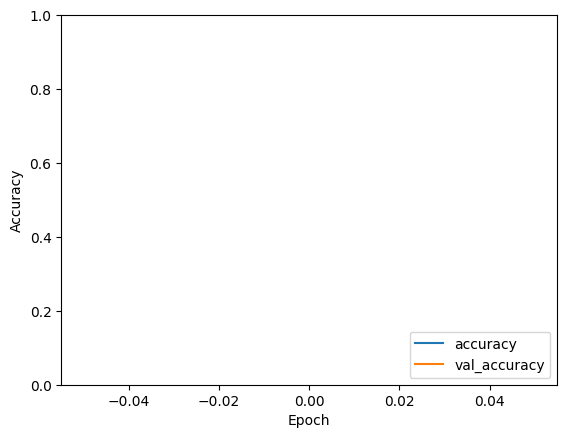

In [55]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [56]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

8/8 [==============================] - 0s 6ms/step
[[111  11]
 [ 31  97]]
Confusion matrix, without normalization
[[111  11]
 [ 31  97]]


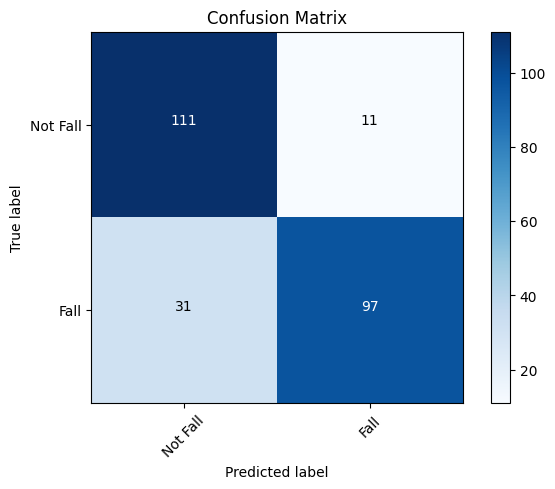

In [57]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ResNet24.predict(X_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

In [58]:
ResNet24.save('ResNet24.keras')  # The file needs to end with the .keras extension


In [59]:
# quantize_scope = tfmot.quantization.keras.quantize_scope
# with quantize_scope(
#   {'DefaultLSTMQuantizeConfig': DefaultLSTMQuantizeConfig,
#    'CustomLSTM': CustomLSTM}):
#   # Use `quantize_apply` to actually make the model quantization aware.
#   q_ConvLSTM = tfmot.quantization.keras.quantize_model(ConvLSTM)
  
q_ResNet24 = tfmot.quantization.keras.quantize_model(ResNet24)
q_ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_ResNet24.summary()


Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 50, 9)                3         ['input_3[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_reshape_5 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer[0][0]']      
 rapperV2)                                                                                        
                                                                                           

In [60]:
q_history = q_ResNet24.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 47s 135ms/step - loss: 1.0210 - accuracy: 0.7920 - val_loss: 0.1912 - val_accuracy: 0.9321 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 33s 131ms/step - loss: 0.7643 - accuracy: 0.8435 - val_loss: 0.4056 - val_accuracy: 0.8528 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 34s 133ms/step - loss: 0.6812 - accuracy: 0.8577 - val_loss: 1.4528 - val_accuracy: 0.4041 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 34s 132ms/step - loss: 0.6362 - accuracy: 0.8704 - val_loss: 0.3331 - val_accuracy: 0.8674 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 34s 133ms/step - loss: 0.6195 - accuracy: 0.8697 - val_loss: 0.2913 - val_accuracy: 0.8872 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.8717
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
256/256 [========

In [61]:
q_ResNet24.save('q_ResNet24.keras')  # The file needs to end with the .keras extension

In [62]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmp4845fg38/assets


INFO:tensorflow:Assets written to: /tmp/tmp4845fg38/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-07 21:25:25.443197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-07 21:25:25.443744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-07 21:25:25.450805: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4845fg38
2023-12-07 21:25:25.486415: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-07 21:25:25.486446: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4845fg38
2023-12-07 21:25:25.549683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLI

In [63]:
open("./q_ResNet24.tflite", "wb").write(quantized_tflite_model)

109472